# Segmentation + Post-process Example

In [1]:
import GPyEDS
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from GPyEDS import utils, GPAM

## Load Data

Data in this case is present as a set of CSV files - one for each element. Therefore they can be loaded in and just simply stacked on top of each other. 

Realistically most data should be simple to load using Hyperspy. Load the data using the instructions shown on their page. Extract the underlying data from the loaded Hyperspy object as Numpy array (should also be in Hyperspy docs) and can be used here.

In [16]:
#define list of elements
elements = ['Al', 'Mg', "Ca", "Si", "O", "Fe", "Na", "Cr"]

#load in maps
maps = []
for item in elements:
    maps.append(pd.read_csv("MF06_2side/Montaged Map Data-" + item + " K series.csv").to_numpy())

#stack them
conc_map = np.zeros((maps[0].shape[0], maps[0].shape[1],len(maps)))
for i in range(len(maps)):
    conc_map[:,:,i] += maps[i]

Inspect counts summed up across the spectral dimension:


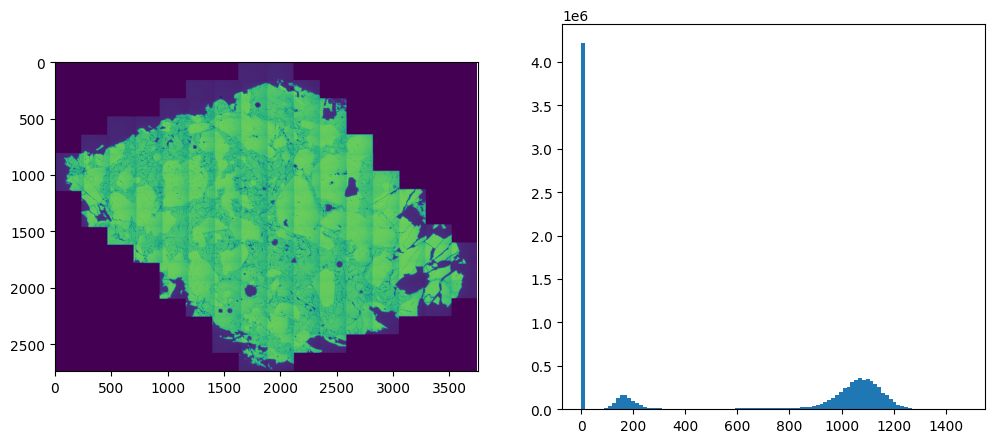

In [17]:
m = np.sum(conc_map, axis = -1)
fig, ax = plt.subplots(1,2, figsize = (12,5))
ax[0].imshow(m)
_ = ax[1].hist(m.ravel(), 100)

Set mask as any pixel with over 400 counts. This eliminates the large regions where no sample is seen. Using a combination of "conc\_map" and "mask" we can ignore all those pixels in the following operations.

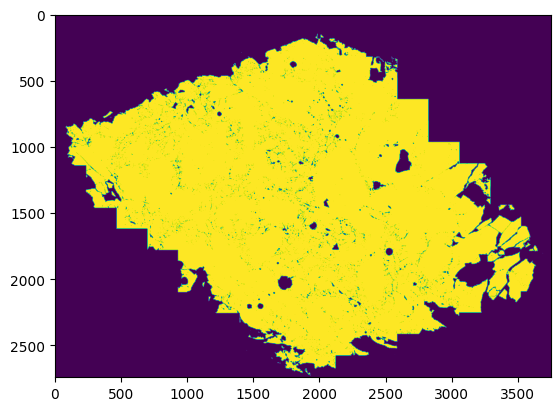

In [18]:
mask = m>400
plt.imshow(mask)

[0.85925553 0.09367569 0.02446468 0.01307037 0.00513371 0.00218746]
Decomposition processing time (s): 32.3215537071228


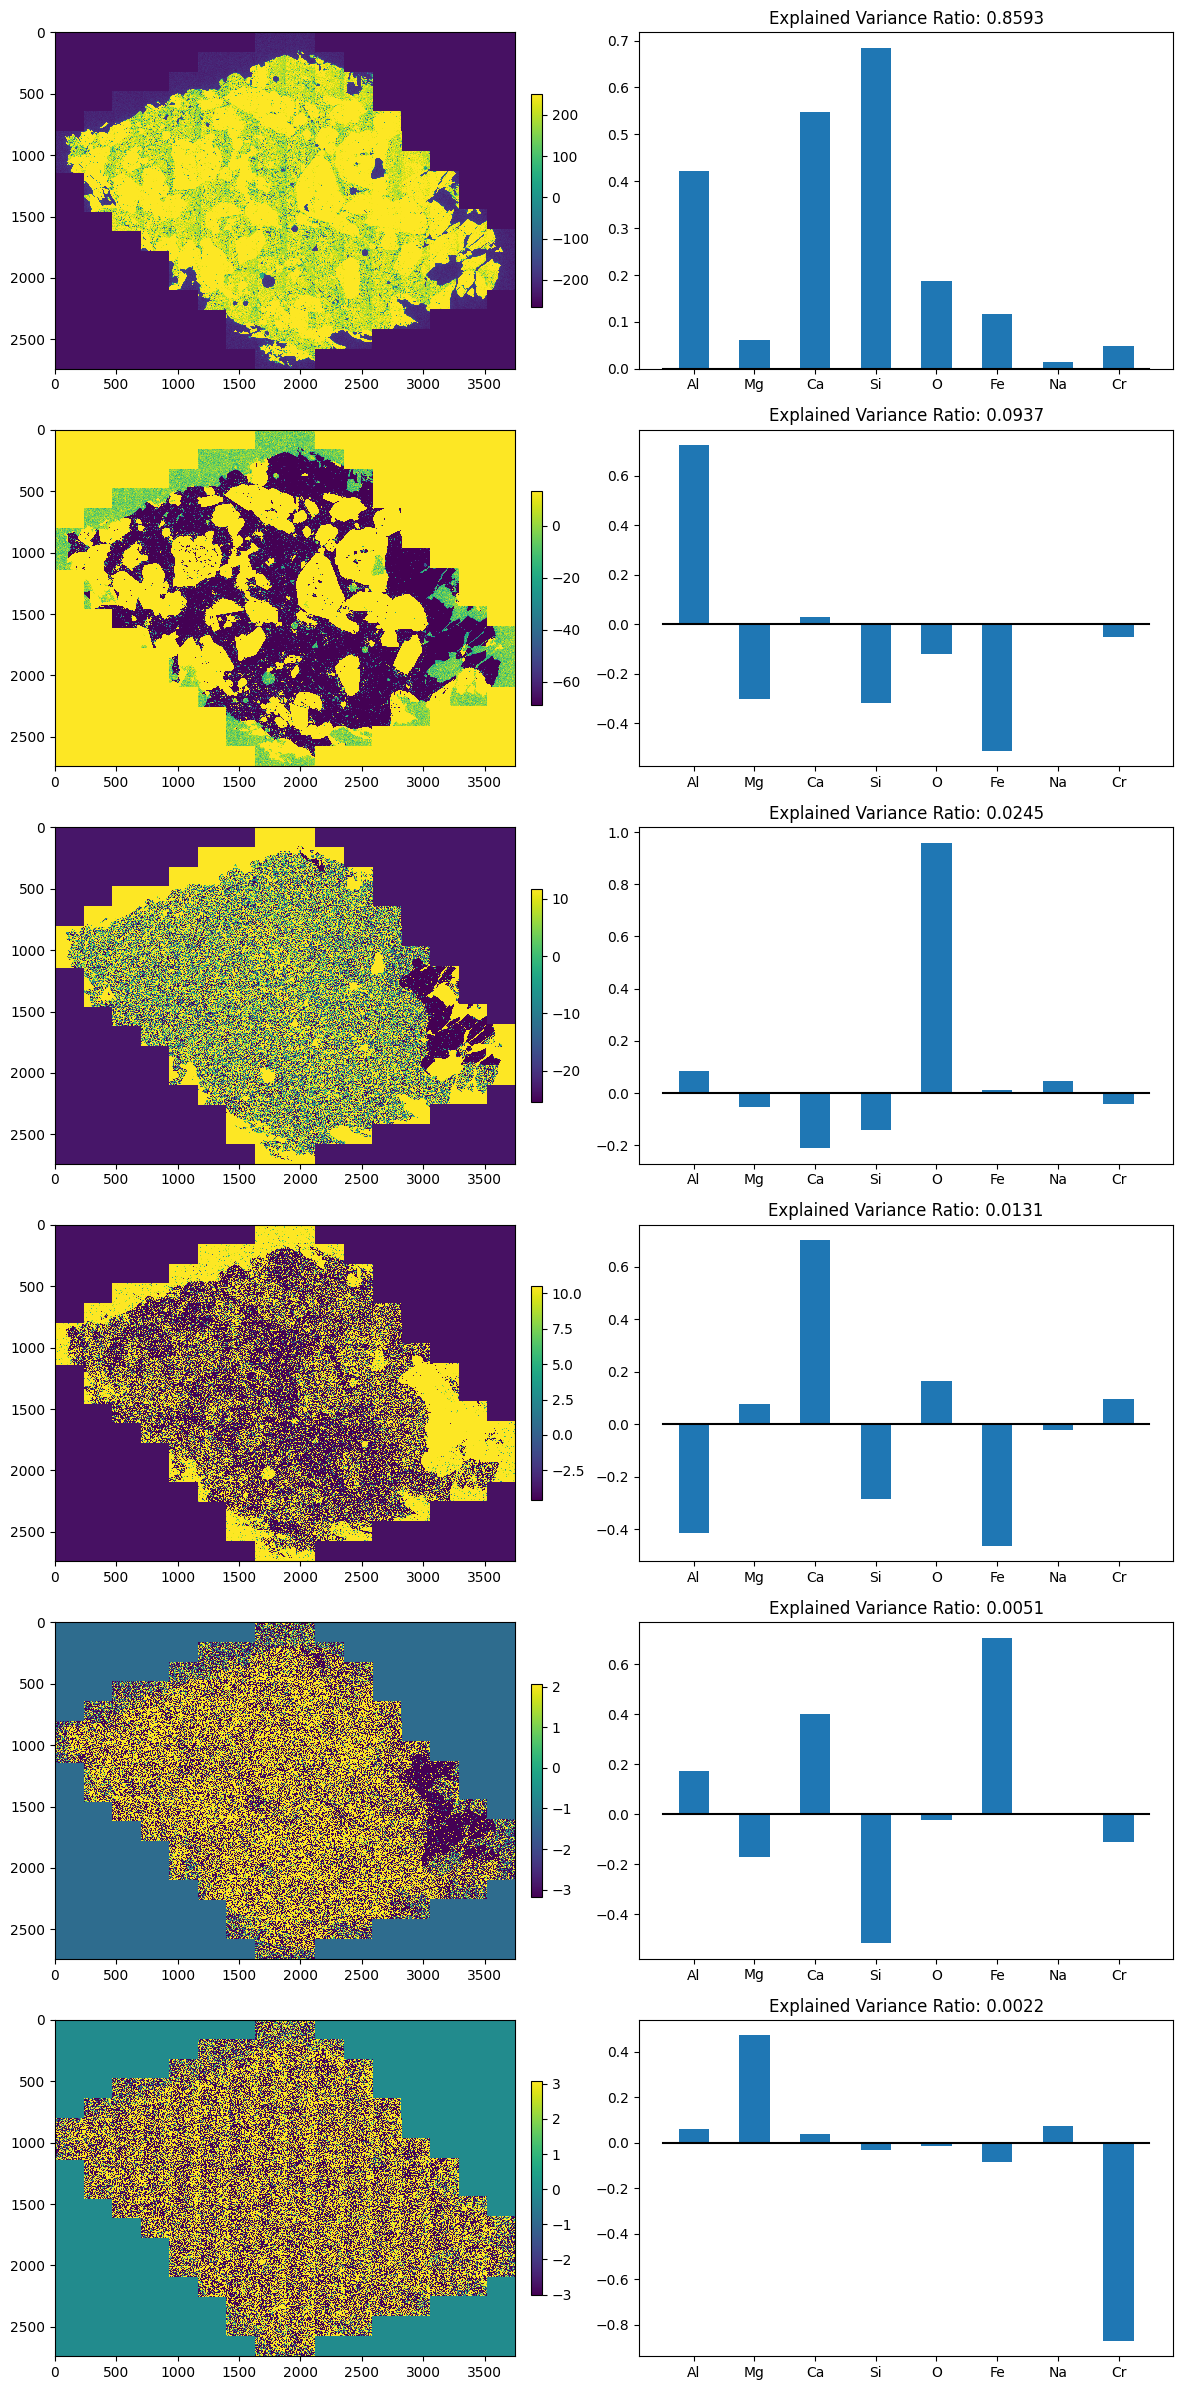

In [20]:
dummy_mask = np.ones((conc_map.shape[0], conc_map.shape[1]), dtype = "bool")

_ = utils.decompose(np.nan_to_num(conc_map), n_components = 6, data_mask = dummy_mask, plot = True, elements=elements)

In [22]:
conc_map = utils.remove_pc_comp(conc_map, comp2remove=0)

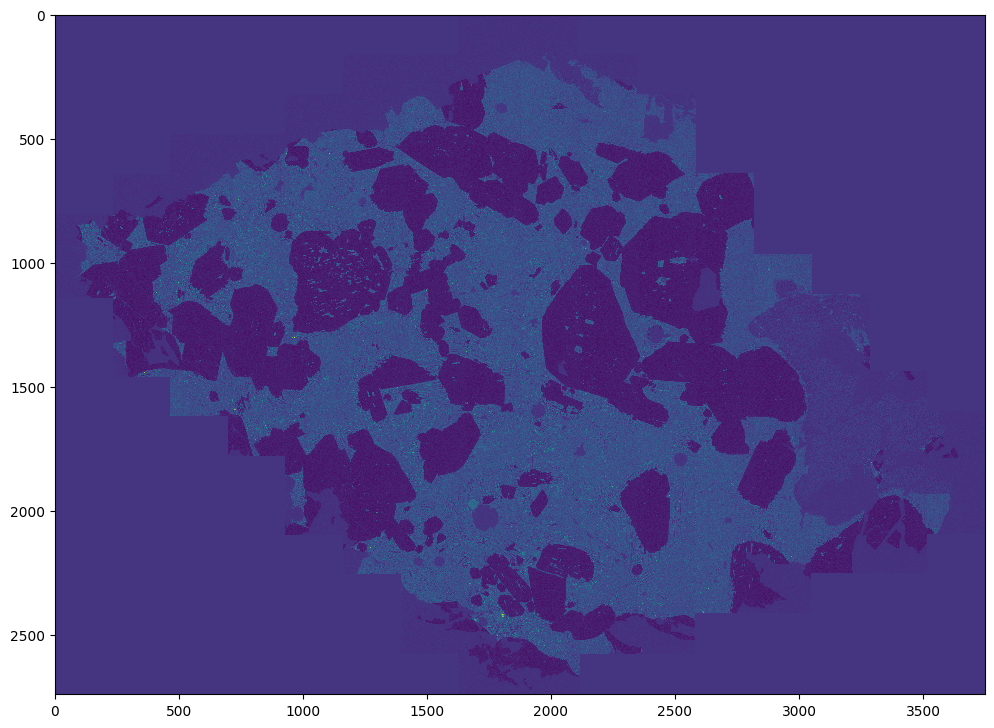

In [23]:
fig = plt.figure(figsize=(12,12))
plt.imshow(conc_map[:,:,5], interpolation="none")

## Segmentation

In [7]:
array = np.nan_to_num(conc_map[mask.astype("bool")])
array_norm, params =utils.feature_normalisation(array[::1, :], return_params=True)

model, encoder, decoder = GPAM.create_two_layer_GPAM_from_data(array_norm, return_layers=True)

c:\Users\norbe\anaconda3\envs\gpyeds_test_env\lib\site-packages\gpflux\layers\gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=2` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(
c:\Users\norbe\anaconda3\envs\gpyeds_test_env\lib\site-packages\gpflux\layers\gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=8` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


### Model Training

In [8]:
history = model.fit({"inputs": array_norm[::10,:], "targets": array_norm[::10,:]}, epochs=int(10), batch_size=200, shuffle = True)

Epoch 1/10
2497/2497 [==============================] - 18s 6ms/step - loss: -16.3430 - gp_layer_prior_kl: 5.9129e-05 - gp_layer_1_prior_kl: 1.4519e-04
Epoch 2/10
2497/2497 [==============================] - 14s 6ms/step - loss: -20.5732 - gp_layer_prior_kl: 9.0746e-05 - gp_layer_1_prior_kl: 2.7126e-04
Epoch 3/10
2497/2497 [==============================] - 14s 6ms/step - loss: -20.7652 - gp_layer_prior_kl: 1.1253e-04 - gp_layer_1_prior_kl: 3.2849e-04
Epoch 4/10
2497/2497 [==============================] - 15s 6ms/step - loss: -20.9198 - gp_layer_prior_kl: 1.3968e-04 - gp_layer_1_prior_kl: 3.5361e-04
Epoch 5/10
2497/2497 [==============================] - 13s 5ms/step - loss: -21.0033 - gp_layer_prior_kl: 1.6473e-04 - gp_layer_1_prior_kl: 3.8169e-04
Epoch 6/10
2497/2497 [==============================] - 15s 6ms/step - loss: -21.2698 - gp_layer_prior_kl: 1.9274e-04 - gp_layer_1_prior_kl: 4.2940e-04
Epoch 7/10
2497/2497 [==============================] - 15s 6ms/step - loss: -21.3294 - 

In [9]:
z, v = GPAM.model_inference(array_norm, encoder)

100%|██████████| 250/250 [00:26<00:00,  9.47it/s]


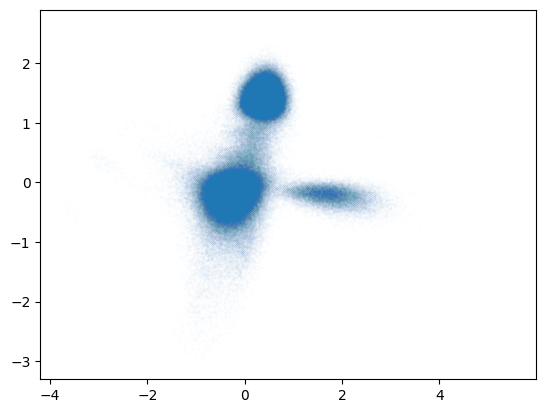

In [13]:
plt.scatter(z[::10,0], z[::10,1], s = 0.0001)

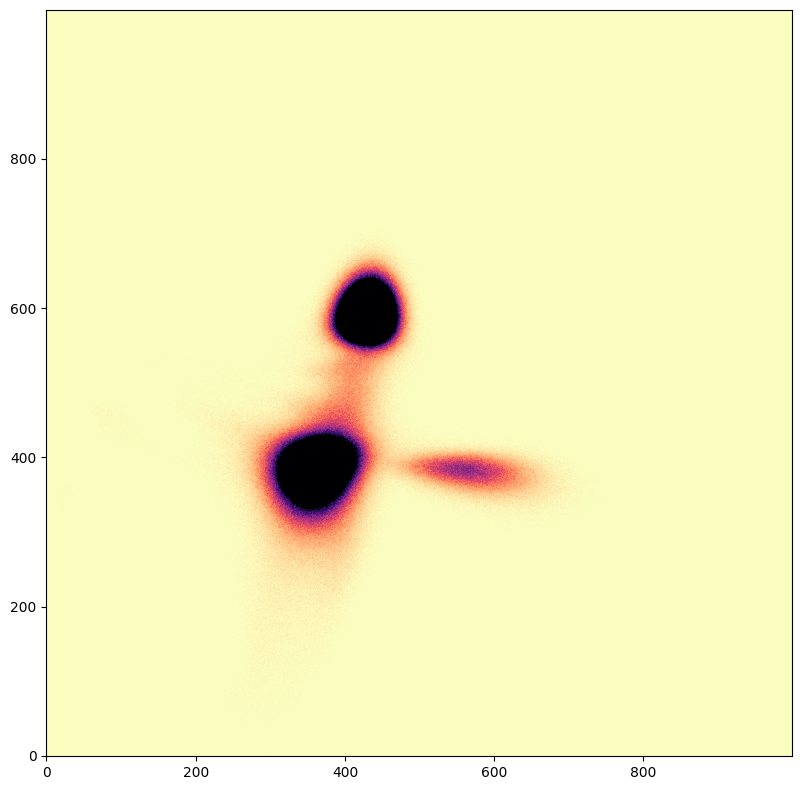

In [11]:
intensity = np.histogram2d(z[:,1],z[:,0],  bins = 1000, density = True)

fig, ax = plt.subplots(1,1,figsize = (12,8))
m = ax.imshow(-intensity[0]/np.sum(intensity[0]), vmin = -0.0000195, cmap = "magma")

plt.gca().invert_yaxis()
fig.tight_layout()

### Clustering

Here we will use scikit-learn's functions to cluster - K-means clustering, a simple approach, should work just fine for this simple dataset.

In [24]:
from sklearn.cluster import KMeans
kmm = KMeans(n_clusters = 3).fit(z[::10])

c:\Users\norbe\anaconda3\envs\gpyeds_test_env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [25]:
l = kmm.predict(z)

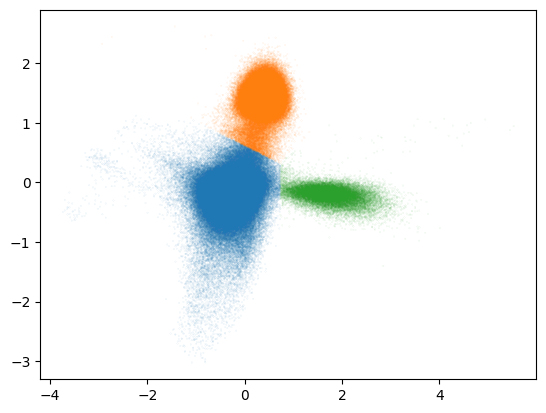

In [29]:
plt.scatter(z[::10,0], z[::10,1], c = l[::10], s = 0.001, cmap = "tab10", vmin = 0, vmax = 9)

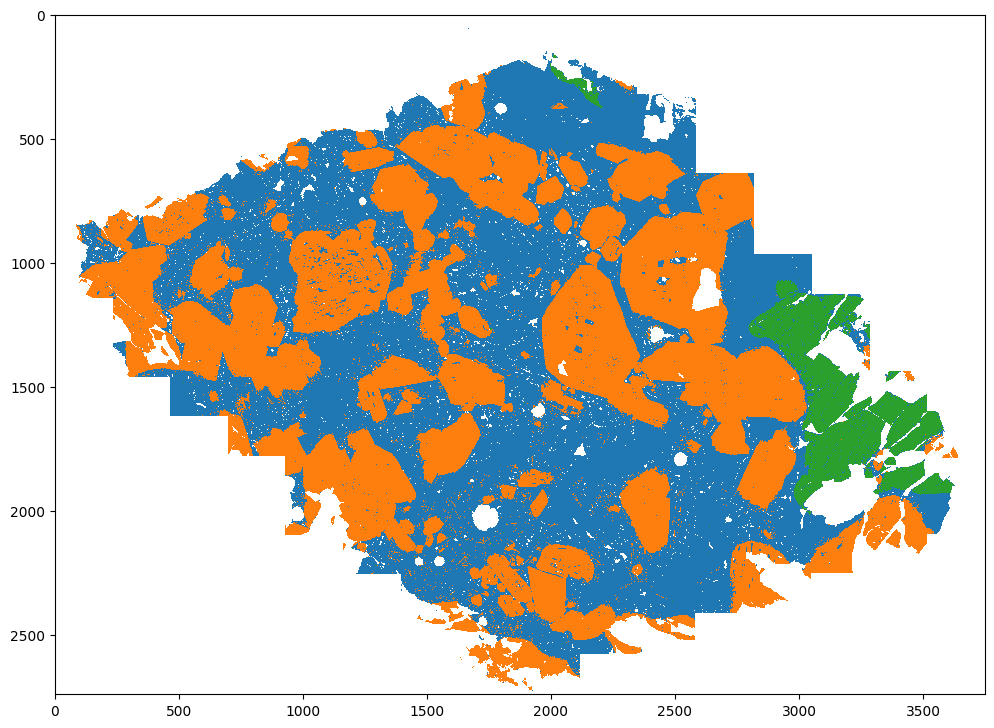

In [28]:
_ = plt.figure(figsize=(12,12))
plt.imshow(utils.get_img(l.astype("float32"), mask.astype("float32")), interpolation="none", cmap = "tab10", vmin = 0, vmax = 9)

## PCA

Will take a singular phase here and showcase PCA.

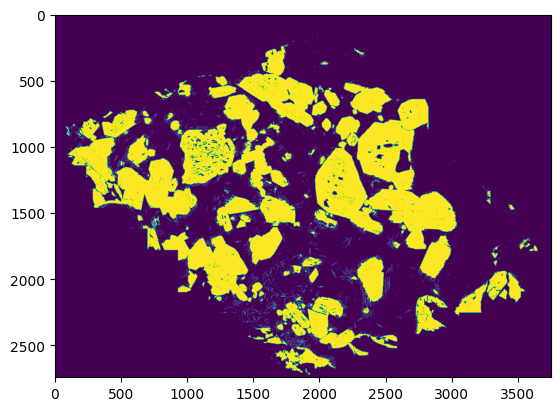

In [34]:
#phase mask image
phase = utils.get_img(l == 1, mask)
phase[~mask] = 0
plt.imshow(phase)

Can use decompose function here to get compositional variability:

[0.33423659 0.29715792 0.17735935]
Decomposition processing time (s): 3.944002151489258


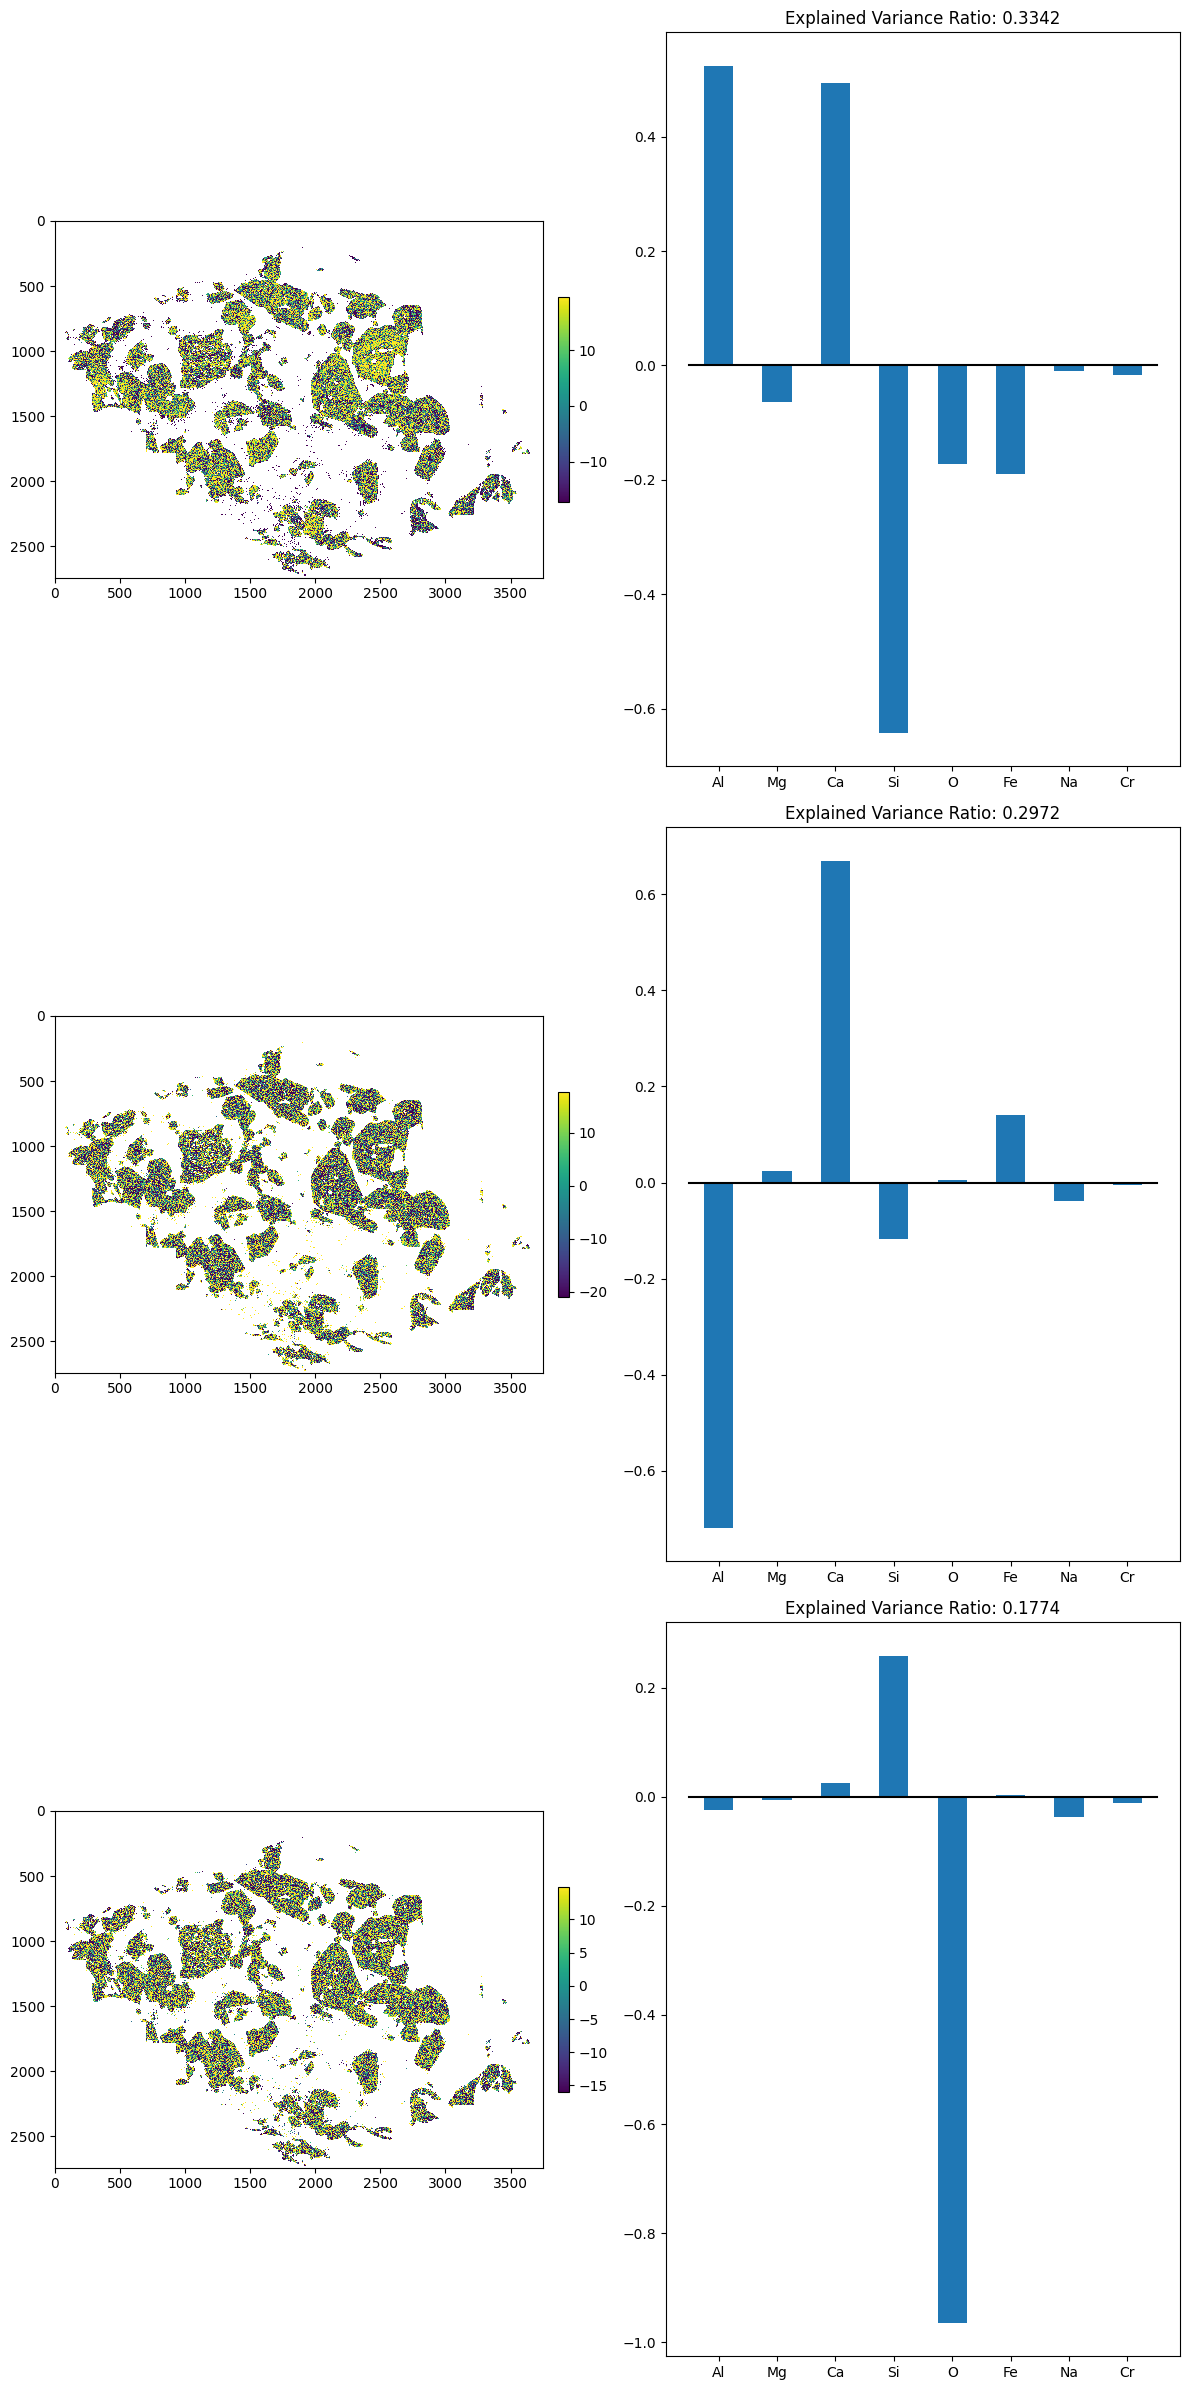

In [36]:
scores, comps = utils.decompose(conc_map[phase.astype("bool")], n_components = 3, data_mask = phase, plot = True, elements=elements)

Take first component that seems to be An-Ab zoning in plagioclase:

In [38]:
scores.shape

(2741, 3750, 3)

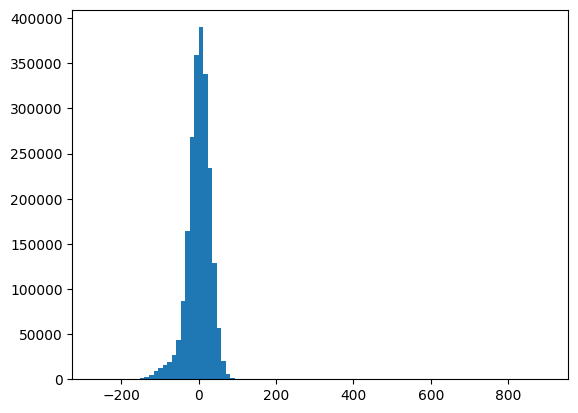

In [40]:
_ = plt.hist(scores[:,:,0].ravel(), 100)

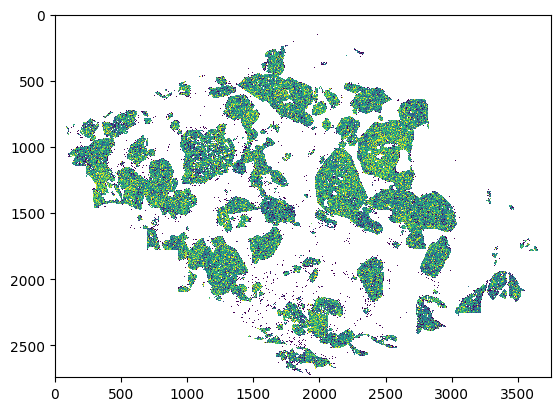

In [42]:
plt.imshow(scores[:,:,0], interpolation="none", vmin = -50, vmax = 50)

Above picture is too noisy - let's look at filtering/smoothing it a little:

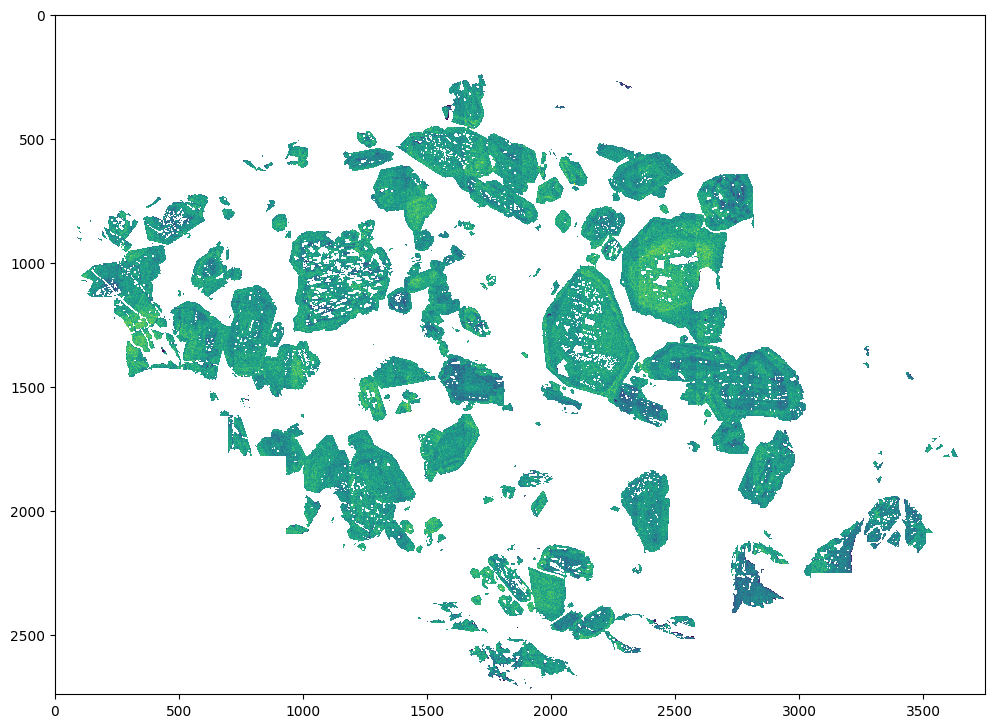

In [48]:
from GPyEDS import spatial_filters
fig = plt.figure(figsize = (12,12))
filt = spatial_filters.linear_filter(scores[:,:,0], mask = phase, range_=2, type = "gaussian")

plt.imshow(filt, interpolation = "none", vmin = -50, vmax = 50)